In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/Anthracnose/chili'

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_files, val_files, test_files = [], [], []

class_names = os.listdir(base_dir)
class_names = [c for c in class_names if os.path.isdir(os.path.join(base_dir, c))]

for class_name in class_names:
    class_dir = os.path.join(base_dir, class_name)
    all_files = [os.path.join(class_dir, fname) for fname in os.listdir(class_dir) if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]

    train_val, test = train_test_split(all_files, test_size=test_ratio, random_state=42)
    train, val = train_test_split(train_val, test_size=val_ratio/(train_ratio + val_ratio), random_state=42)

    train_files += train
    val_files += val
    test_files += test

print("Total Train:", len(train_files))
print("Total Val:", len(val_files))
print("Total Test:", len(test_files))

train_dir = train_files
val_dir = val_files
test_dir = test_files

Mounted at /content/drive
Total Train: 803
Total Val: 174
Total Test: 173


In [ ]:
IMG_SIZE = (224, 224)
def preprocess_image(file_path):
    img = load_img(file_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    return img_array / 255.0

def get_labels(file_list):
    return [os.path.basename(os.path.dirname(path)) for path in file_list]

X_train = np.array([preprocess_image(path) for path in train_files])
y_train = get_labels(train_files)

X_val = np.array([preprocess_image(path) for path in val_files])
y_val = get_labels(val_files)

X_test = np.array([preprocess_image(path) for path in test_files])
y_test = get_labels(test_files)

encoder = LabelEncoder()
y_train = to_categorical(encoder.fit_transform(y_train))
y_val = to_categorical(encoder.transform(y_val))
y_test = to_categorical(encoder.transform(y_test))

num_classes = y_train.shape[1]

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.4525 - loss: 1.4013 - val_accuracy: 0.7586 - val_loss: 0.6540
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.6707 - loss: 0.7072 - val_accuracy: 0.8448 - val_loss: 0.3627
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.8609 - loss: 0.4011 - val_accuracy: 0.8621 - val_loss: 0.2740
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.8944 - loss: 0.2844 - val_accuracy: 0.8966 - val_loss: 0.2073
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.9329 - loss: 0.2046 - val_accuracy: 0.9253 - val_loss: 0.1905


In [ ]:
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Accuracy: {acc*100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8429 - loss: 0.5284

Test Accuracy: 90.17%


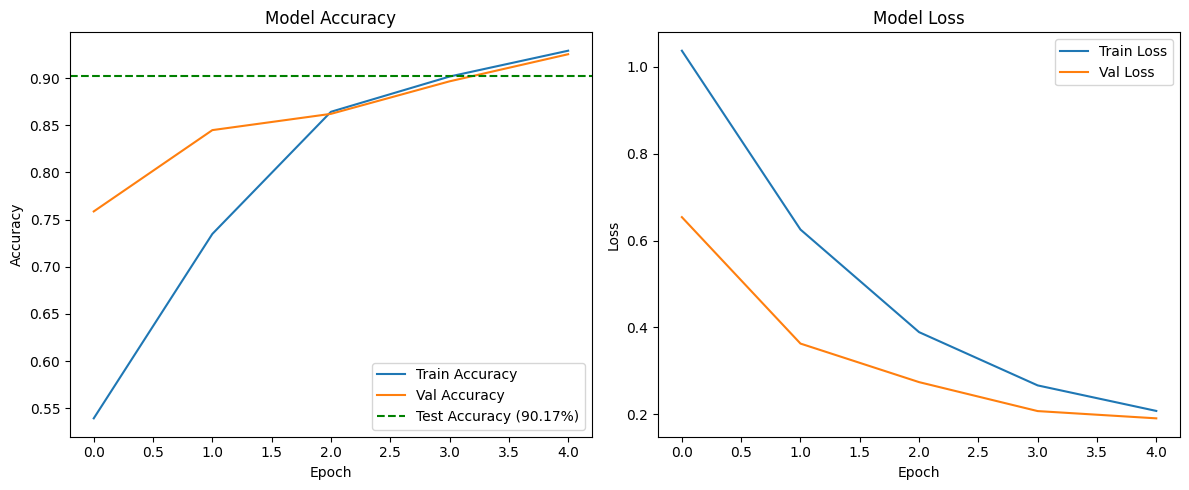

In [ ]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.axhline(y=acc, color='green', linestyle='--', label=f'Test Accuracy ({acc*100:.2f}%)')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
os.makedirs("tflite", exist_ok=True)
with open("tflite/label.txt", "w") as f:
    for label in class_names:
        f.write(f"{label}\n")

In [ ]:
# Menyimpan model ke dalam format .h5
model.save("model_cnn.h5")
print("Model berhasil disimpan sebagai model_cnn.h5")

Model berhasil disimpan sebagai model_cnn.h5


In [ ]:
model.save('model_no_optimizer.h5', include_optimizer=False)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Model CNN ringan
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,779 (91.20 MB)

 Trainable params: 23,907,779 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("Jumlah kelas:", y_train.shape[1])

Jumlah kelas: 3


In [ ]:
# Asumsikan data pelatihan dan validasi telah disiapkan dalam variabel x_train, y_train, x_val, y_val

# Melatih model ringan
#history = model2.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val), verbose=2)
history2 = model2.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=32)

# Menampilkan akurasi pelatihan dan validasi
train_acc2 = history2.history['accuracy'][-1]
val_acc2 = history2.history['val_accuracy'][-1]

print(f"Akurasi Pelatihan: {train_acc2 * 100:.2f}%")
print(f"Akurasi Validasi: {val_acc2 * 100:.2f}%")

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.4082 - loss: 7.4203 - val_accuracy: 0.7356 - val_loss: 0.7492
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.7165 - loss: 0.6371 - val_accuracy: 0.8391 - val_loss: 0.5052
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.8580 - loss: 0.4180 - val_accuracy: 0.9023 - val_loss: 0.2964
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.9334 - loss: 0.2433 - val_accuracy: 0.8851 - val_loss: 0.2596
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.9453 - loss: 0.1578 - val_accuracy: 0.9483 - val_loss: 0.1653
Akurasi Pelatihan: 95.52%
Akurasi Validasi: 94.83%


In [ ]:
loss2, acc2 = model2.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Accuracy: {acc2*100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 525ms/step - accuracy: 0.8994 - loss: 0.3178

Test Accuracy: 90.75%


In [ ]:
model2.save('model2_no_optimizer.h5', include_optimizer=False)

In [ ]:
model.export("saved_model/chili_model")

Saved artifact at 'saved_model/chili_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140467832576656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140467832577232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140467832581456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140467832579728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140467832580880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140467832582224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140467832572240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140467832582608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140467832582992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140467832584528: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/chili_model")

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open("chili_model_optimized.tflite", "wb") as f:
    f.write(tflite_model)

print("Model berhasil dikonversi dan disimpan ke chili_model_optimized.tflite")


Model berhasil dikonversi dan disimpan ke chili_model_optimized.tflite


In [ ]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    saved_model/chili_model tfjs_model


2025-05-27 18:29:25.107732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748370565.130265   22883 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748370565.137284   22883 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-27 18:29:31.014198: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1748370571.159894   22883 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

batas